In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"] = 12

from scipy import special, integrate
import os
import sys
sys.path.insert(0, '/home/aew492/CFE_gradients/code')
from generate_mock_list import MockSet

### mock parameters

In [3]:
L = 750
n = '2e-4'
As = 2
nmocks = 1000

### input power spectrum

In [4]:
# for As2x
PkG_fn = f'/scratch/ksf293/mocks/lognormal/inputs/cat_L{int(L)}_n{n}_z057_patchy_As{As}x_pkG.dat'
kG, PkG = np.loadtxt(PkG_fn).T

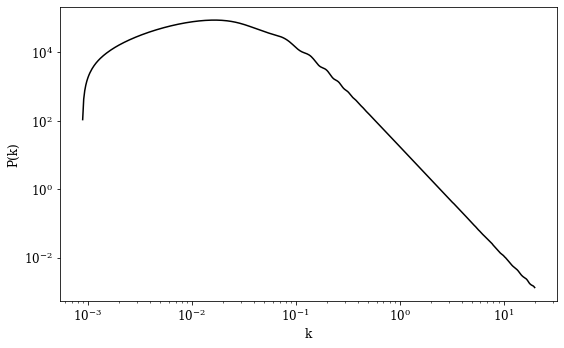

In [5]:
fig, ax = plt.subplots(figsize=(8,5))

ax.plot(kG, PkG, color='k')

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('k')
ax.set_ylabel('P(k)')
# ax.set_title('Input power spectra')
fig.tight_layout()

### example mock catalog slice

In [6]:
mockset = MockSet(L, n, rlzs=1)
mock_dict = mockset.load_rlz(0)
mock_data = mock_dict['data']

In [7]:
mock_data -= L/2

In [8]:
# xy-slice for plotting
z_max = -200
data_slice = mock_data[np.where(mock_data[:,2] < z_max)]

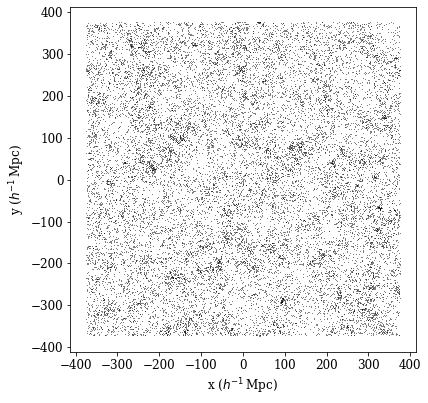

In [9]:
fig, ax = plt.subplots(figsize=(6,6))

ax.plot(data_slice[:,0], data_slice[:,1], 'k,', alpha=0.5)

ax.set_aspect('equal')
ax.set_xlabel('x ($h^{-1}\,$Mpc)')
ax.set_ylabel('y ($h^{-1}\,$Mpc)')
fig.tight_layout()

### LS results for a single mock set

In [10]:
L = 750
n = '2e-4'
nmocks = 1000
mockset = MockSet(L, n, rlzs=nmocks)
mockset.load_xi_lss()

In [11]:
r = mockset.r_avg
xi_avg = np.mean(mockset.xi_lss, axis=0)
xi_std = np.std(mockset.xi_lss, axis=0)

In [12]:
xi_avg.shape, xi_std.shape

((22,), (22,))

In [13]:
mockset.r_avg.shape

(22,)

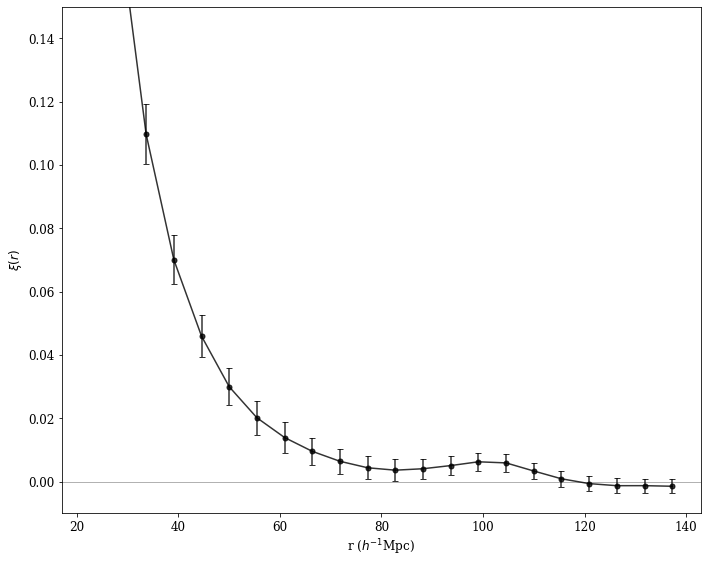

In [14]:
fig, ax = plt.subplots(figsize=(10,8))

ax.errorbar(r, xi_avg, xi_std, color='k', marker='.', lw=1.5, ms=10, alpha=0.8, capsize=3)

ax.axhline(0, color='k', alpha=0.3, lw=1)
ax.set_ylim((-.01, 0.15))
ax.set_xlabel(r'r ($h^{-1}$Mpc)')
ax.set_ylabel(r'$\xi(r)$')
fig.tight_layout()

#### LS results for other number densities

In [15]:
# mock parameters
L = 750
ns_str = ['1e-6', '1e-5', '1e-4', '2e-4', '1e-3']  # L750_n4e-4 directory is empty in /ksf293
ns_flt = [float(n) for n in ns_str]
As = 2
nmocks = 1000

In [16]:
# load in Landy-Szalay results
xi_vars = []
for i, n in enumerate(ns_str):
    mockset = MockSet(L, n, As=As, rlzs=nmocks)
    mockset.load_xi_lss()
    r = mockset.r_avg
    xi_var = np.var(mockset.xi_lss, axis=0)
    xi_vars.append(xi_var)

In [17]:
avg_vars = np.mean(xi_vars, axis=1)

Text(0, 0.5, '$\\Delta\\xi^2$(r)')

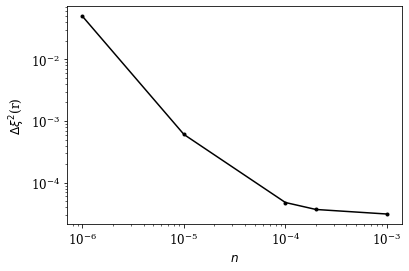

In [18]:
plt.plot(ns_flt, avg_vars, 'k.-')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$n$')
plt.ylabel(r'$\Delta\xi^2$(r)')

### predicted variance in $\xi$ as a function of $r$

In [19]:
# ** predicted variance in the 2pcf at a certain length scale r
def xi_err_pred(r, V, n, k, Pk, nk=1000):

    # interpolate between the discrete (k, Pk) values to get a finer scale for integration
    kfine = np.linspace(min(k), max(k), nk)
    Pkfine = np.interp(kfine, k, Pk)
    
    # multiplicative constant
    const = 1 / (2*np.pi*V)

    # function of k that we want to integrate
    def k_func(k, Pk):
        return (k/r) * (Pk+(1/n))**2 * (special.jv(1/2, k*r))**2

    # construct our array, and integrate using trapezoid rule
    k_func_arr = np.array([k_func(k, Pkfine[i]) for i, k in enumerate(kfine)])
    trapz = integrate.trapz(k_func_arr, x=kfine)

    return const*trapz

In [20]:
def compute_predicted_xi_err_fixed_n(rs, kG, PkG, n, kmin=None, kmax=None):
    nbins = len(rs)

    # optionally, only integrate over part of the input power spectrum in k_func()
    idx = (kG>kmin)&(kG<kmax)
    kG = kG[idx]
    PkG = PkG[idx]
    # print("after cuts:")
    # print(len(k), len(PkG_))

    # get predicted variances using xi_err_pred()
    pred_vars = np.empty(nbins)
    for i, r in enumerate(rs):
        pred_vars[i] = xi_err_pred(r, L**3, float(n), kG, PkG)

    return pred_vars

In [21]:
# k bounds
# kmin = 2*np.pi/L
# kmax = 20

kmin = min(kG)
kmax = max(kG)

In [22]:
rfine = np.linspace(min(r), max(r), 100)

In [23]:
# bias
b = 2.0

In [24]:
# rfine, kG, PkG, kmin, kmax, and bias all defined above
n = '2e-4'
print(kmin, kmax)
pred_var_fixed_n = compute_predicted_xi_err_fixed_n(rfine, kG, PkG, n, kmin=kmin, kmax=kmax)

0.0008912509381 19.95262315


In [25]:
pred_var_interp = np.interp(r, rfine, pred_var_fixed_n)

In [26]:
pred_var_interp.shape

(22,)

In [27]:
res = pred_var_interp - xi_std**2

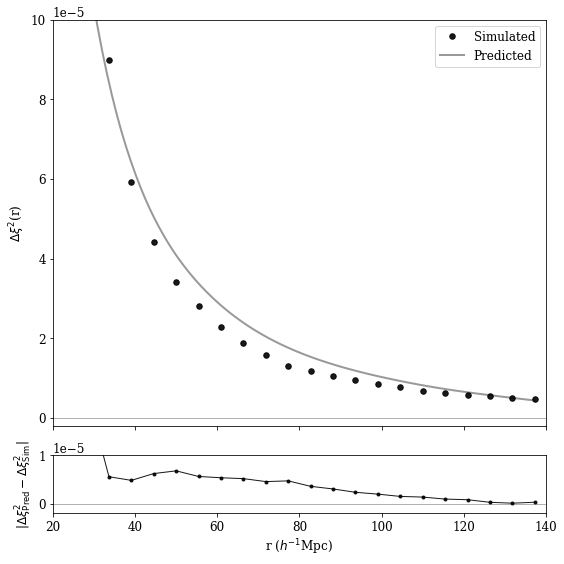

In [28]:
fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(8,8), gridspec_kw={'height_ratios': [7, 1]})

ax1.plot(r, xi_std**2, color='k', ls='None', marker='.', alpha=0.9, ms=11, zorder=10, label='Simulated')
ax1.plot(rfine, pred_var_fixed_n, color='k', ls='-', alpha=0.4, lw=2, label='Predicted')

ax1.set_ylim((-2e-6,1e-4))
ax1.set_ylabel(r'$\Delta\xi^2$(r)')
ax1.xaxis.set_tick_params(labelbottom=False)
ax1.legend()

ax2.plot(r, np.abs(res), color='k', marker='.', lw=1, alpha=0.9)
ax2.set_ylim((-2e-6, 1e-5))
ax2.set_ylabel(r'$\vert\Delta\xi^2_\mathrm{Pred} - \Delta\xi^2_\mathrm{Sim}\vert$')
ax2.set_xlabel(r'r ($h^{-1}$Mpc)')

for ax in [ax1, ax2]:
    ax.set_xlim((20,140))
    ax.axhline(0, color='k', alpha=0.3, lw=1)
fig.tight_layout()

In [33]:
max(res)

6.7610324396964286e-06

In [31]:
relative_err_r = (pred_var_interp - xi_std**2)/pred_var_interp

In [32]:
relative_err_r

array([-0.58328921, -0.20003812, -0.06583746,  0.07476037,  0.12295847,
        0.16556634,  0.1660398 ,  0.18889025,  0.21585704,  0.22252089,
        0.26655103,  0.23248557,  0.22482617,  0.19662508,  0.18605993,
        0.15922998,  0.16365708,  0.12741298,  0.12361123,  0.04542525,
       -0.01408754, -0.06136605])

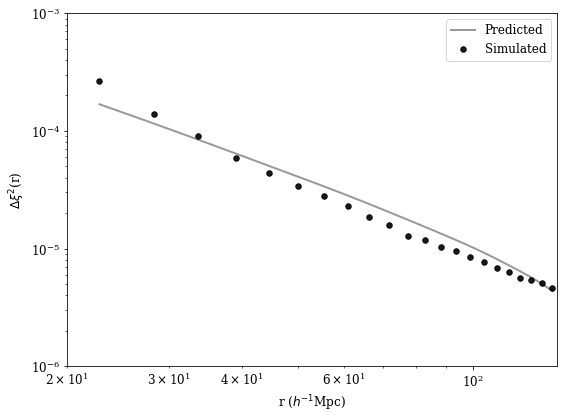

In [29]:
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(rfine, pred_var_fixed_n, color='k', ls='-', alpha=0.4, lw=2, label='Predicted')
ax.plot(r, xi_std**2, color='k', ls='None', marker='.', alpha=0.9, ms=11, label='Simulated')

ax.axhline(0, color='k', alpha=0.3, lw=1)
ax.set_xlim((20,140))
ax.set_ylim((1e-6,1e-3))
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_ylim((-1e-5,1e-4))
ax.set_xlabel(r'r ($h^{-1}$Mpc)')
ax.set_ylabel(r'$\Delta\xi^2$(r)')
fig.tight_layout()
ax.legend()

#### check other number densities

In [34]:
pred_var_fixed_ns = np.empty((len(ns_flt), len(rfine)))
for i, n in enumerate(ns_flt):
    print(ns_str[i], n)
    pred_var_fixed_ns[i] = compute_predicted_xi_err_fixed_n(rfine, kG, PkG, n, kmin=kmin, kmax=kmax)

1e-6 1e-06
1e-5 1e-05
1e-4 0.0001
2e-4 0.0002
1e-3 0.001


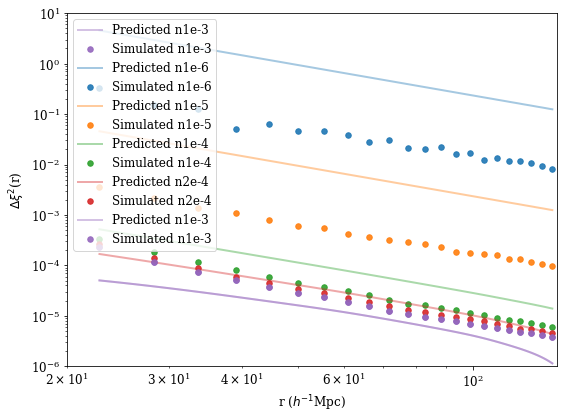

In [35]:
# plot similar results to above
fig, ax = plt.subplots(figsize=(8,6))

cs = ['C0', 'C1', 'C2', 'C3', 'C4']

ax.plot(rfine, pred_var_fixed_ns[i], color=cs[i], ls='-', alpha=0.4, lw=2, label=f'Predicted n{ns_str[i]}')
ax.plot(r, xi_vars[i], color=cs[i], ls='None', marker='.', alpha=0.9, ms=11, label=f'Simulated n{ns_str[i]}')

for i, n in enumerate(ns_flt):
    ax.plot(rfine, pred_var_fixed_ns[i], color=cs[i], ls='-', alpha=0.4, lw=2, label=f'Predicted n{ns_str[i]}')
    ax.plot(r, xi_vars[i], color=cs[i], ls='None', marker='.', alpha=0.9, ms=11, label=f'Simulated n{ns_str[i]}')

ax.axhline(0, color='k', alpha=0.3, lw=1)
ax.set_xlim((20,140))
ax.set_ylim((1e-6,1e1))
# ax.set_ylim((-1e-5,1e-4))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'r ($h^{-1}$Mpc)')
ax.set_ylabel(r'$\Delta\xi^2$(r)')
fig.tight_layout()
ax.legend()

### predicted variance in $\xi$ as a function of $n$

In [36]:
# finer grid of number densities for the theoretical predictions
nfine = np.logspace(np.log10(min(ns_flt)), np.log10(max(ns_flt)), 50)

In [37]:
# for each number density, get the average value of xi_var(r)
# to take the average val of a function: integrate the function over the interval
# and divide by the length of the interval
avg_vars_pred = np.empty(len(nfine))
for i, n in enumerate(nfine):
    pred_var = compute_predicted_xi_err_fixed_n(rfine, kG, PkG, n, kmin=kmin, kmax=kmax)
    # integrate
    trapz = integrate.trapz(pred_var, x=rfine)
    # divide by length
    avg_vars_pred[i] = trapz / (max(rfine)-min(rfine))

In [38]:
pred_var_n_interp = np.interp(ns_flt, nfine, avg_vars_pred)

In [39]:
res = np.abs(pred_var_n_interp - avg_vars)

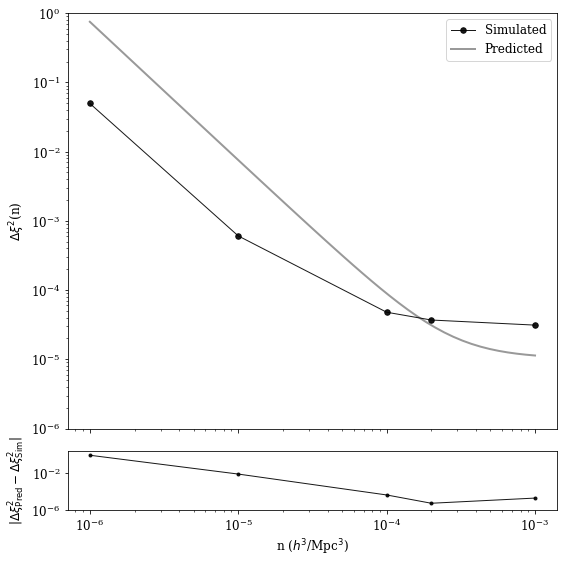

In [40]:
fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(8,8), gridspec_kw={'height_ratios': [7, 1]})
    
ax1.plot(ns_flt, avg_vars, color='k', ls='-', lw=1, marker='.', alpha=0.9, ms=11, label='Simulated')
ax1.plot(nfine, avg_vars_pred, color='k', ls='-', alpha=0.4, lw=2, label='Predicted')
ax1.set_ylim((1e-6,1))
ax1.set_ylabel(r'$\Delta\xi^2$(n)')
ax1.xaxis.set_tick_params(labelbottom=False)
ax1.legend()

ax2.plot(ns_flt, res, color='k', marker='.', lw=1, alpha=0.9)
ax2.set_ylim((1e-6,2))
ax2.set_xlabel(r'n ($h^3$/Mpc$^3$)')
ax2.set_ylabel(r'$\vert\Delta\xi^2_\mathrm{Pred} - \Delta\xi^2_\mathrm{Sim}\vert$')
# ax.set_title(r'Simulation vs. theory results: $\Delta\xi^2(n)$, As2x mocks')

for ax in [ax1, ax2]:
    ax.axhline(0, color='k', lw=1, alpha=0.3)
    ax.set_xscale('log')
    ax.set_yscale('log')
    
fig.tight_layout()

In [41]:
res

array([7.01604814e-01, 7.05050215e-03, 4.26417639e-05, 5.60130017e-06,
       1.98363383e-05])

In [44]:
err = res / avg_vars
print(err)

[14.12653492 11.62652594  0.89003931  0.15156316  0.63596518]
